# Tokenization

## 학습 목표
1. 각 토큰화 기법들을 살펴보고 구현한다.
2. Subword tokenization의 필요성을 직접 느껴본다.

**Context**
1. Character-based tokenization 구현하기
2. Word-based tokenization 구현하기
3. Subword-based tokenization (BertTokenizer) 사용해보기

##0. 필요한 패키지 및 라이브러리 import 하기

In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
nltk.download('punkt')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from datasets import load_dataset

from transformers import BertTokenizer

from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##1. Character-based tokenization 구현하기

```
💡 tokenization이란 ❓

주어진 입력 데이터를 자연어처리 모델이 인식할 수 있는 단위로 변환해주는 방법이다.

가장 기초적인 방법으로는 문자(character) 단위로 쪼개는 것인데,
"I have a meal" 혹은 "나는 밥을 먹는다"라고 하는 문장을 가지고 character tokenization을 하면 다음과 같다.

- ["I", "h", "a", "v", "e", "a", "m", "e", "a", "l"]
- ["나", "는", "밥", "을", "먹", "는", "다"]

해당 tokenization 기법의 장점은 embedding layer 크기가 작다는 것이다.
영어의 경우, 알파벳 26개와 숫자 0~9, 기호 문자 여러 개 정도일 것이다.

하지만 위의 장점은 단점이 되기도 하는데,
예를 들면 "bank"와 "apple"은 서로 다른 단어이지만 동일한 "a" 임베딩이 사용된다.

직접 character tokenization을 구현해서 성능을 살펴보도록 한다.
```

###1-1. 데이터 준비

```
✨ torchtext 라이브러리에서 제공하는 CoLA 데이터셋을 통해 tokenization 성능을 측정해보고자 한다.

CoLA는 문법 감정 데이터셋으로써, 문장이 문법적인지 문법적이지 않은지 분류하는 binary classification task에 활용된다.

각 데이터 샘플마다 문장과 해당 라벨이 존재하고,
라벨이 0이라면 문법이 틀린 문장이고, 1이라면 문법이 맞는 문장을 뜻한다.

8,550개의 training data와 515개의 test data로 구성되어 있다.
```
참고1: https://pytorch.org/text/stable/datasets.html#cola

참고2: https://nyu-mll.github.io/CoLA/

In [12]:
# 본 실습에서는 모델 학습에 초점을 두지 않기에 평가(dev) 데이터셋은 로드하지 않는다.
dataset = load_dataset('glue', 'cola')
train_iter, test_iter = dataset['train'], dataset['test']
train_iter = [(el['idx'], el['label'], el['sentence']) for el in train_iter]
test_iter = [(el['idx'], el['label'], el['sentence']) for el in test_iter]

In [13]:
print("# Train:", len(list(train_iter)))
print("# Test:", len(list(test_iter)))

# Train: 8551
# Test: 1063


In [14]:
# 데이터셋 예제
for doc_id, label, sent in train_iter:
    print(f"Doc ID: {doc_id}")
    print(f"Label: {label}")
    print(f"Sentence: {sent}")
    break

Doc ID: 0
Label: 1
Sentence: Our friends won't buy this analysis, let alone the next one we propose.


###1-2. Character Tokenizer 만들기

>토크나이저(Tokenizer)는 총 세 가지를 수행한다.
> 1. 텍스트를 원하는 토큰 단위(character, word, subword)로 쪼갠 후,
> 2. 토큰을 단어장(vocabulary)에 저장한 다음,
> 3. 각 토큰을 단어장에 매핑(mapping)되어 있는 고유번호(id)로 변환한다.

```
💡 단어장(vocabulary)이란❓

토큰을 고유번호(id)로 매핑해주는 사전(dictionary)이라고 생각하면 된다.
언어 모델이 자연어 텍스트를 그대로 이해할 수 없기 때문에 처리 가능한 숫자로 변환하는 것이다.

일반적으로 학습 데이터셋에서 본 토큰들로 단어장을 구축한다.
혹여나 추론 데이터셋에서 학습 데이터셋에서 보지 못한 단어를 접하면 unknown 특수 토큰으로 대체한다.
```

In [15]:
class CharTokenizer(object):

    PAD_TOKEN = "<pad>"     # 배치화를 할 때 모든 입력을 같은 길이로 맞춰 주기 위한 패딩 토큰
    UNK_TOKEN = "<unk>"     # vocab에 없는 character가 들어왔을 때 unknown token으로 변환

    def __init__(self):
        self.char2idx = {self.PAD_TOKEN: 0, self.UNK_TOKEN: 1}
        self.idx2char = [self.PAD_TOKEN, self.UNK_TOKEN]

        self.__build_vocab()    # 단어장(vocab) 구축

    def tokenize(self, text):
        # 텍스트를 문자 단위로 쪼갠다. 단어장에 존재하지 않는다면 "<unk>"로 대체한다.
        return [char if char in self.char2idx else self.UNK_TOKEN for char in text]

    def encode(self, text):
        # 텍스트를 문자 단위로 쪼갠 후, 고유번호로 변환한다. 단어장에 존재하지 않는다면 unknown token의 고유번호로 대체한다.
        return [self.char2idx[char] if char in self.char2idx else self.char2idx[self.UNK_TOKEN] for char in text]

    def __add_char(self, char):
        if char not in self.char2idx:
            self.idx2char.append(char)
            self.char2idx[char] = len(self.idx2char) - 1    # idx2char 리스트의 길이가 늘었으므로, 다음 문자의 고유번호는 자동으로 increment 된다.
        return self.char2idx[char]

    def __build_vocab(self):
        for _, _, sent in train_iter:
            for char in sent:
                self.__add_char(char)

    def __len__(self):
        return len(self.idx2char)

In [16]:
# 토크나이저 선언
char_tokenizer = CharTokenizer()

> `__len__()`는 Python 내장 함수로써, 클래스의 길이를 `len()`로 call 할 수 있다.

In [17]:
print(f"Character vocabulary 크기: {len(char_tokenizer)}")

Character vocabulary 크기: 86


> 단어장이 잘 구축이 되어있는지 첫 10개의 토큰을 프린트해본다.

In [18]:
print(f"Character vocabulary: {char_tokenizer.idx2char[:10]}")

Character vocabulary: ['<pad>', '<unk>', 'O', 'u', 'r', ' ', 'f', 'i', 'e', 'n']


> 모르는 문자가 들어왔을 때, unknown 토큰으로 잘 대체되는지 확인해본다.

In [19]:
char_tokenizer.tokenize("I am 배고파.")

['I', ' ', 'a', 'm', ' ', '<unk>', '<unk>', '<unk>', '.']

> `encode()` 함수가 고유번호로 잘 변환하는지 확인한다.

In [20]:
char_tokenizer.encode("I am 배고파.")

[28, 5, 19, 25, 5, 1, 1, 1, 24]

> `Dataset` 클래스를 구현한다.
>
> PyTorch 라이브러리를 활용해 언어 모델을 GPU 학습하기 위해서는 데이터를 배치화 시켜주는 `DataLoader`에 데이터를 넣어주어야 하는데, 데이터가 `Dataset` 형태로 입력이 주어져야 한다.
>
> `Dataset` 클래스에는 최소 세 가지의 함수를 필요로 한다.
>
> 1. `__init__()` : 일반적인 Python의 constructor이다. 변수들을 initialize 하는 데 사용된다.
> 2. `__len__()` : 데이터셋의 길이, 즉 데이터 샘플 수를 리턴한다.
> 3. `__getitem__(idx)` : `idx` 파라미터를 받았을 때, 해당 인덱스의 데이터 샘플을 리턴한다. 자연어 태스크 경우 보통 입력 문장("x")과 해당 라벨("y")를 리턴한다.

In [21]:
class CharDataset(Dataset):
    def __init__(self, split):
        self.x = []
        self.y = []

        if split == "train":
            for _, label, sent in train_iter:
                self.x.append(char_tokenizer.encode(sent))  # 문장을 고유번호로 변환 후 데이터 리스트에 append
                self.y.append(label)
        elif split == "test":
            for _, label, sent in test_iter:
                self.x.append(char_tokenizer.encode(sent))
                self.y.append(label)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [22]:
# split에 따라 각각 학습과 추론 데이터셋을 선언한다.
train_set = CharDataset(split="train")
test_set = CharDataset(split="test")

> 💡 Character로 토큰화를 했을 때 각 샘플의 길이는 매우 길어진다.

In [23]:
print(f"Character tokenized 샘플 예제: {train_set[0]}")

Character tokenized 샘플 예제: ([2, 3, 4, 5, 6, 4, 7, 8, 9, 10, 11, 5, 12, 13, 9, 14, 15, 5, 16, 3, 17, 5, 15, 18, 7, 11, 5, 19, 9, 19, 20, 17, 11, 7, 11, 21, 5, 20, 8, 15, 5, 19, 20, 13, 9, 8, 5, 15, 18, 8, 5, 9, 8, 22, 15, 5, 13, 9, 8, 5, 12, 8, 5, 23, 4, 13, 23, 13, 11, 8, 24], 1)


###1-3. RNN 모델 구현하기

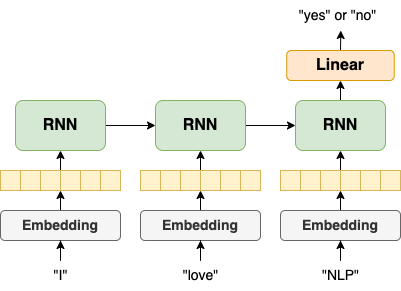

> 토크나이저 성능을 측정하기 위해 간단한 RNN 모델을 정의한다.

> `RNNModel`은 다음과 같은 파라미터를 받는다.
> - `vocab_size`: 단어장의 크기, 토크나이저의 길이
> - `input_size`: 각 토큰 벡터의 차원
> - `hidden_size`: RNN의 hidden state 차원
> - `output_size`: 클래스의 수
> - `num_layers`: RNN의 층 수
> - `bidirectional`: 양방향 RNN (True/False)
> - `rnn_type`: LSTM or GRU

In [24]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, output_size, num_layers, bidirectional=True, rnn_type="lstm"):
        super(RNNModel, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type
        self.dropout = nn.Dropout(p=0.1)
        self.embed = nn.Embedding(vocab_size, input_size)

        if rnn_type == "lstm":
            # nn.RNN 계열은 default로 텐서를 (seq, batch, feature)로 리턴하기 때문에, batch_first=True를 꼭 넣어줘야 (batch, seq, feature)로 리턴한다.
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)

        # bidirectional RNN은 forward와 backward hidden state 두개가 있기 때문에 linear layer의 크기가 두배로 된다.
        self.fc = nn.Linear(2 * hidden_size if bidirectional else hidden_size, output_size)

    def forward(self, input_text, lengths):
        token_embeddings = self.dropout(self.embed(input_text))

        # 다양한 길이의 패딩된 입력을 "pack"하여 좀 더 효율적으로 연산한다. (PyTorch documentation 참고)
        token_embeddings = pack_padded_sequence(token_embeddings, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)

        if self.rnn_type =="lstm":
            _, (hidden, cell) = self.rnn(token_embeddings)  # LSTM은 추가로 cell state을 리턴한다.
        elif self.rnn_type == "gru":
            _, hidden = self.rnn(token_embeddings)

        if self.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=-1)    # bidirectional일 경우 forward와 backward hidden state를 결합한다.
            out = self.fc(hidden)
        else:
            out = self.fc(hidden[-1])   # last hidden state만 사용한다.
        return out

In [25]:
char_model = RNNModel(vocab_size=len(char_tokenizer),
                      input_size=256,    # token embedding size
                      hidden_size=256,   # hidden state dimension
                      output_size=1,     # binary classification을 regression problem으로 접근
                      num_layers=2)

print(char_model)

RNNModel(
  (dropout): Dropout(p=0.1, inplace=False)
  (embed): Embedding(86, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)    # gradient가 흐르는 총 파라미터 수를 계산한다.

In [27]:
print(f"Char embedding parameter 개수: {count_parameters(char_model.embed)}")
print(f"RNN parameter 개수: {count_parameters(char_model.rnn)}")

Char embedding parameter 개수: 22016
RNN parameter 개수: 2629632


###1-4. Character-based tokenizer 성능 평가

In [28]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


```
💡 collate_fn이란❓

입력 텍스트의 길이는 항상 일정할 수가 없다. 모든 샘플을 같은 사이즈로 만들 수 있는 이미지 데이터와는 다르게,
텍스트 데이터는 패딩(padding)을 통해 배치 내의 샘플들의 길이를 일정 사이즈로 맞춰 주어야 한다.

데이터 전처리를 할 때부터 모든 샘플들의 길이를 max sequence length로 설정하는 방법도 있지만, 이 경우 샘플들의 평균 길이가 길어져 모델 학습 시간이 늘어나는 단점이 있다.
collate_fn 함수를 사용하면 배치에서 가장 긴 길이의 샘플을 기준으로 나머지 샘플들을 패딩할 수 있다.
이러한 과정을 dynamic batching이라고도 칭한다.

PyTorch의 DataLoader에 collate_fn 함수를 넣을 수 있는 방법을 살펴보도록 한다.
```

In [29]:
def char_collate_fn(batch):
    PAD = char_tokenizer.char2idx[char_tokenizer.PAD_TOKEN]         # 토크나이저의 패딩 토큰의 고유번호

    # dynamic batching
    lengths = [len(b[0]) for b in batch]
    max_len = max(lengths)  # 배치 내에서 가장 긴 텍스트 길이
    sents = [b[0] + [PAD] * (max_len - len(b[0])) for b in batch]   # 배치 내에서 가장 긴 텍스트 길이까지 패딩
    labels = [b[1] for b in batch]

    # 텐서화
    sents = torch.LongTensor(sents)
    lengths = torch.LongTensor(lengths)     # RNNModel에서 pack_padded_sequence()를 쓰기 위해 필요
    labels = torch.FloatTensor(labels)      # Regression으로 풀기 때문에 label은 float type이여야 한다.
    return sents, lengths, labels

In [30]:
train_loader = DataLoader(train_set,        # Dataset 클래스 형태의 데이터를 입력으로 넣어준다
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=char_collate_fn,
                          drop_last=True,   # 마지막 배치가 batch_size보다 작을 때 쓰지 않고 버린다
                          pin_memory=True)  # CPU에 있는 데이터를 GPU로 빠른 transfer를 가능하게 한다
test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=False,
                         collate_fn=char_collate_fn,
                         drop_last=False)

Epoch:  1| Step   500	| Loss: 0.613
Epoch:  2| Step  1000	| Loss: 0.609


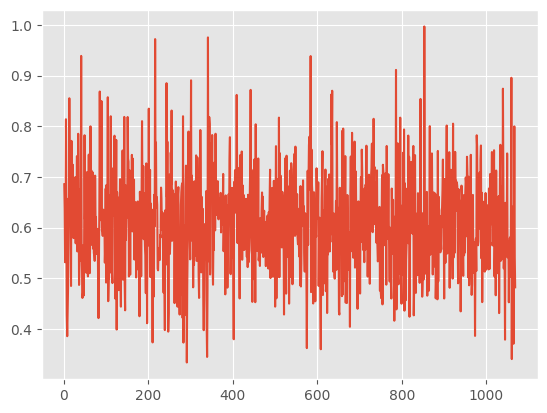

In [31]:
# 학습
char_model.train()
char_model = char_model.to(device)
optimizer = torch.optim.Adam(char_model.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss(reduction="mean")  # 배치 내 샘플들의 loss를 평균화 한다

step = 0
steps = []
loss_list = []

for e in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        sents, lengths, labels = batch
        sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
        out = char_model(sents, lengths)

        optimizer.zero_grad()
        # out = (batch_size, 1)
        loss = loss_function(out.squeeze(-1), labels)   # out과 labels의 shape을 동일하게 맞춘다
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

plt.plot(steps, loss_list)

In [32]:
# 추론
char_model.eval()
acc = []

for i, batch in enumerate(test_loader):
    sents, lengths, labels = batch
    sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
    out = char_model(sents, lengths)

    probs = torch.sigmoid(out.squeeze(-1))      # sigmoid로 logit을 0과 1사이 값으로 설정
    preds = torch.zeros_like(probs).to(probs)
    preds[probs > 0.5] = 1.                     # 0.5보다 크면 1로 예측
    num_correct = ((preds == 1) * (labels == 1)).sum()
    acc.append(num_correct / len(labels))

print(f"Average accuracy: {sum(acc) / len(acc)}")

Average accuracy: 0.0


##2. Word-based tokenization 구현하기

```
💡 Word tokenizer의 장점은 서로 다른 단어에 다른 토큰을 사용한다는 것이다.

앞서 사용했던 character tokenizer은 "bank"와 "apple"의 "a"가 같은 토큰 임베딩을 활용했다.

하지만 word tokenizer는 "bank"와 "apple"이 각 하나의 토큰이 됨으로써,
명확히 다른 의미를 모델이 배울 수 있게 된다.

이 또한 문제점이 있는데,
모델이 보지 못한 단어에 대한 out-of-vocabulary (OOV) 문제가 있는 것과,
word embedding의 크기가 압도적으로 커진다는 것이다.
```

###2-1. Word Tokenizer 만들기

In [33]:
class WordTokenizer(object):

    PAD_TOKEN = "<pad>"
    UNK_TOKEN = "<unk>"

    def __init__(self):
        self.word2idx = {self.PAD_TOKEN: 0, self.UNK_TOKEN: 1}
        self.idx2word = [self.PAD_TOKEN, self.UNK_TOKEN]

        self.__build_vocab()

    def tokenize(self, text):
        # split() 함수를 통해 텍스트를 단어 단위(공백 기준)로 쪼갠다.
        return [word if word in self.word2idx else self.UNK_TOKEN for word in text.split()]

    def encode(self, text):
        return [self.word2idx[word] if word in self.word2idx else self.word2idx[self.UNK_TOKEN] for word in text.split()]

    def __add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __build_vocab(self):
        for _, _, sent in train_iter:
            for word in sent.split():
                self.__add_word(word)

    def __len__(self):
        return len(self.idx2word)

In [34]:
word_tokenizer = WordTokenizer()

> 문자 단위 토크나이저와 단어장 크기 비교를 했을 때, 단어 단위 토크나이저의 단어장 크기가 압도적으로 큰 것을 확인할 수 있다.

In [35]:
print(f"Character vocabulary 크기: {len(char_tokenizer)}")
print(f"Word vocabulary 크기: {len(word_tokenizer)}")

Character vocabulary 크기: 86
Word vocabulary 크기: 8258


In [36]:
print(f"Word vocabulary: {word_tokenizer.idx2word[:10]}")

Word vocabulary: ['<pad>', '<unk>', 'Our', 'friends', "won't", 'buy', 'this', 'analysis,', 'let', 'alone']


> 공백 기준으로 단어를 쪼개기 때문에, "배고파."가 하나의 unknown 토큰으로 대체된다.

In [37]:
word_tokenizer.tokenize("I am 배고파.")

['I', 'am', '<unk>']

In [38]:
word_tokenizer.encode("I am 배고파.")

[292, 474, 1]

In [39]:
class WordDataset(Dataset):
    def __init__(self, split):
        self.x = []
        self.y = []

        if split == "train":
            for _, label, sent in train_iter:
                self.x.append(word_tokenizer.encode(sent))
                self.y.append(label)
        elif split == "test":
            for _, label, sent in test_iter:
                self.x.append(word_tokenizer.encode(sent))
                self.y.append(label)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [40]:
train_set = WordDataset(split="train")
test_set = WordDataset(split="test")

> 💡 Word로 토큰화를 했을 때 단어장의 크기는 커졌지만 각 샘플의 길이는 굉장히 짧아졌다. 이 뜻은 GPU 메모리를 더 많이 쓸 수 있다는 뜻도 된다.

In [41]:
print(train_set[0])

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 1)


###2-2. RNN 모델

> 💡 위에서 정의한 RNNModel 함수를 그대로 쓸 수 있다.

In [42]:
word_model = RNNModel(vocab_size=len(word_tokenizer),   # vocab_size, 즉 임베딩 층의 크기만 달라진다.
                      input_size=256,
                      hidden_size=256,
                      output_size=1,
                      num_layers=2)

print(word_model)

RNNModel(
  (dropout): Dropout(p=0.1, inplace=False)
  (embed): Embedding(8258, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


> 각 단어마다 벡터가 존재하게 되기 때문에 임베딩 층 파라미터 수가 압도적으로 높아진 것을 확인할 수 있다.

In [43]:
print(f"Char embedding parameter 개수: {count_parameters(char_model.embed)}")
print(f"Word embedding parameter 개수: {count_parameters(word_model.embed)}")

Char embedding parameter 개수: 22016
Word embedding parameter 개수: 2114048


###2-3. Word-based tokenizer 성능 평가

In [44]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [45]:
def word_collate_fn(batch):
    PAD = word_tokenizer.word2idx[word_tokenizer.PAD_TOKEN]

    lengths = [len(b[0]) for b in batch]
    max_len = max(lengths)
    sents = [b[0] + [PAD] * (max_len - len(b[0])) for b in batch]
    labels = [b[1] for b in batch]

    sents = torch.LongTensor(sents)
    lengths = torch.LongTensor(lengths)
    labels = torch.FloatTensor(labels)
    return sents, lengths, labels

In [46]:
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=word_collate_fn,
                          drop_last=True,
                          pin_memory=True)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=False,
                         collate_fn=word_collate_fn,
                         drop_last=False)

Epoch:  1| Step   500	| Loss: 0.610
Epoch:  2| Step  1000	| Loss: 0.559


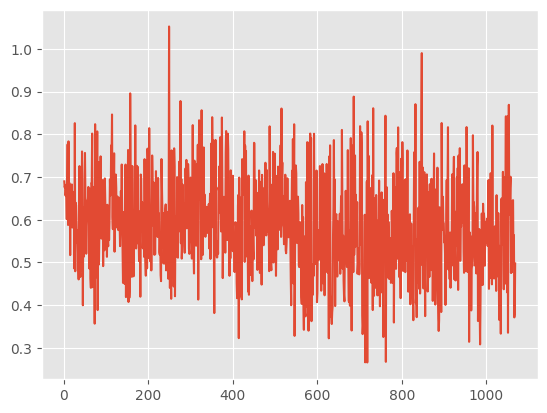

In [47]:
# 학습
word_model.train()
word_model = word_model.to(device)
optimizer = torch.optim.Adam(word_model.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss(reduction="mean")

step = 0
steps = []
loss_list = []

for e in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        sents, lengths, labels = batch
        sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
        out = word_model(sents, lengths)

        optimizer.zero_grad()
        loss = loss_function(out.squeeze(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

plt.plot(steps, loss_list)

In [48]:
# 추론
word_model.eval()
acc = []

for i, batch in enumerate(test_loader):
    sents, lengths, labels = batch
    sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
    out = word_model(sents, lengths)

    probs = torch.sigmoid(out.squeeze(-1))
    preds = torch.zeros_like(probs).to(probs)
    preds[probs > 0.5] = 1.
    num_correct = ((preds == 1) * (labels == 1)).sum()
    acc.append(num_correct / len(labels))

print(f"Average accuracy: {sum(acc) / len(acc)}")

Average accuracy: 0.0


##3. Subword-based tokenization (BertTokenizer) 사용해보기

```
Subword tokenization의 장점은 out-of-vocabulary (OOV) 문제에서 상대적으로 자유롭다는 것이다.

일반적으로 subword들은 최소 철자 단위에서 하나씩 더 긴 subword를 추가하는 방식으로 만들어진다.

예를 들어, 영어의 경우 a~z의 알파벳부터 시작해서 두글자, 세글자, 네글자 subword 등으로 확장해나가며
subword를 추가해 단어를 구성하고 이를 바탕으로 subword tokenization을 수행하기 때문에 다른 언어를 tokenization하지 않는다면 OOV 문제에서 자유롭다고 볼 수 있다.

Subword tokenizer를 구현하기 위해서는 word를 어떻게 쪼갤지에 대한 다양한 알고리즘이 존재한다.
대표적으로 byte-pair encoding (BPE), Wordpiece, Sentencepiece 등이 있다.
이런 알고리즘들을 본 실습에서 직접 구현하기에는 다소 복잡하기 때문에 BERT 모델에서 사전 학습된 Wordpiece 기반 토크나이저를 사용해보고자 한다.

해당 subword tokenizer는 transformers 라이브러리를 이용해 쉽게 불러올 수 있다.
```
참고: [Huggingface: subword tokenization](https://huggingface.co/transformers/tokenizer_summary.html#subword-tokenization)

###3-1. BertTokenizer로 Subword Tokenizer 만들기

In [49]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
print(bert_tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [50]:
# subword tokenization 예시
print(bert_tokenizer.tokenize('BERT Tokenizer is a subword tokenizer.'))

['B', '##ER', '##T', 'To', '##ken', '##izer', 'is', 'a', 'sub', '##word', 'token', '##izer', '.']


> Huggingface 토크나이저의 `encode()` 함수는 subword token들을 고유번호로 변환해줄뿐더러 앞 뒤로 `[CLS]` classification 토큰과 `[SEP]` separation 토큰이 붙는다. BERT 모델의 입력이 실제로 들어가는데, 이유에 대한 자세한 내용은 BERT 논문을 참고하기 바란다.

참고: https://arxiv.org/abs/1810.04805

In [51]:
print(bert_tokenizer.encode('BERT Tokenizer is a subword tokenizer.'))

[101, 139, 9637, 1942, 1706, 6378, 17260, 1110, 170, 4841, 12565, 22559, 17260, 119, 102]


In [52]:
print(bert_tokenizer.convert_ids_to_tokens([101, 139, 9637, 1942, 1706, 6378, 17260, 1110, 170, 4841, 12565, 22559, 17260, 119, 102]))

['[CLS]', 'B', '##ER', '##T', 'To', '##ken', '##izer', 'is', 'a', 'sub', '##word', 'token', '##izer', '.', '[SEP]']


In [53]:
print(bert_tokenizer.decode([101, 139, 9637, 1942, 1706, 6378, 17260, 1110, 170, 4841, 12565, 22559, 17260, 119, 102]))

[CLS] BERT Tokenizer is a subword tokenizer. [SEP]


> 토크나이저의 특수 토큰들은 다음과 같이 불러올 수 있다.

In [54]:
print(bert_tokenizer.cls_token)
print(bert_tokenizer.unk_token)
print(bert_tokenizer.pad_token)
print(bert_tokenizer.sep_token)
print(bert_tokenizer.mask_token)

[CLS]
[UNK]
[PAD]
[SEP]
[MASK]


> 사전 학습된 BERT Tokenizer를 그대로 사용할 수 있지만, 우리가 앞서 구현한 Character Tokenizer과 Word Tokenizer와 공정한 비교를 위해 새로운 Subword Tokenizer 클래스를 정의한다.
>
> Bert Tokenizer의 토큰들을 사용하되, CoLA 학습 데이터셋에 존재하는 토큰들만 단어장에 추가한다.

In [55]:
class SubwordTokenizer(object):

    PAD_TOKEN = bert_tokenizer.pad_token
    UNK_TOKEN = bert_tokenizer.unk_token
    CLS_TOKEN = bert_tokenizer.cls_token
    SEP_TOKEN = bert_tokenizer.sep_token
    MASK_TOKEN = bert_tokenizer.mask_token

    def __init__(self):
        self.token2idx = {self.PAD_TOKEN: 0, self.UNK_TOKEN: 1, self.CLS_TOKEN: 2, self.SEP_TOKEN: 3, self.MASK_TOKEN: 4}
        self.idx2token = [self.PAD_TOKEN, self.UNK_TOKEN, self.CLS_TOKEN, self.SEP_TOKEN, self.MASK_TOKEN]

        self.__build_vocab()

    def tokenize(self, text):
        tokens = bert_tokenizer.tokenize(text)  # tokenize() 함수를 사용하여 subword 단위로 쪼갠다
        return [token if token in self.token2idx else self.UNK_TOKEN for token in tokens]

    def encode(self, text):
        tokens = bert_tokenizer.tokenize(text)
        return [self.token2idx[token] if token in self.token2idx else self.token2idx[self.UNK_TOKEN] for token in tokens]

    def __add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __build_vocab(self):
        for _, _, sent in train_iter:
            tokens = bert_tokenizer.tokenize(sent)
            for token in tokens:
                self.__add_token(token)

    def __len__(self):
        return len(self.idx2token)

In [56]:
subword_tokenizer = SubwordTokenizer()

> Subword tokenizer의 단어장 크기는 문자 단위보단 크지만 단어 단위보단 작아진 걸 확인할 수 있다.

In [57]:
print(f"Character vocabulary 크기: {len(char_tokenizer)}")
print(f"Word vocabulary 크기: {len(word_tokenizer)}")
print(f"Subword vocabulary 크기: {len(subword_tokenizer)}")

Character vocabulary 크기: 86
Word vocabulary 크기: 8258
Subword vocabulary 크기: 5958


> "generalization"의 접미사 "##ization"은 추가로 쪼개지면서, 다른 곳에 재사용이 가능하다.

In [58]:
print(f"Subword vocabulary: {subword_tokenizer.idx2token[:15]}")

Subword vocabulary: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', 'Our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let']


💡 Subword tokenizer는 OOV 문제를 어느 정도 해결할 수 있다.

In [59]:
print("Word tokenizer output:", word_tokenizer.tokenize("I am supercalifragilisticexpialidocious."))
print("Subword tokenizer output:", subword_tokenizer.tokenize("I am supercalifragilisticexpialidocious."))

Word tokenizer output: ['I', 'am', '<unk>']
Subword tokenizer output: ['I', 'am', '[UNK]', '##cal', '##if', '##rag', '[UNK]', '##tic', '[UNK]', '[UNK]', '##lid', '##oc', '[UNK]', '.']


In [60]:
class SubwordDataset(Dataset):
    def __init__(self, split):
        self.x = []
        self.y = []

        if split == "train":
            for _, label, sent in train_iter:
                self.x.append(subword_tokenizer.encode(sent))
                self.y.append(label)
        elif split == "test":
            for _, label, sent in test_iter:
                self.x.append(subword_tokenizer.encode(sent))
                self.y.append(label)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [61]:
train_set = SubwordDataset(split="train")
test_set = SubwordDataset(split="test")

> 데이터 문장 길이가 문자 단위처럼 엄청 길지도 않고 단어 단위처럼 엄청 짧지도 않은 적절한 길이를 가진다.

In [62]:
print(train_set[0])

([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 1)


###3-2. RNN 모델

In [63]:
subword_model = RNNModel(vocab_size=len(subword_tokenizer),
                         input_size=256,
                         hidden_size=256,
                         output_size=1,
                         num_layers=2)

print(subword_model)

RNNModel(
  (dropout): Dropout(p=0.1, inplace=False)
  (embed): Embedding(5958, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


> 임베딩 층의 파라미터 수도 적절한 것을 확인할 수 있다.

In [64]:
print(f"Char embedding parameter 개수: {count_parameters(char_model.embed)}")
print(f"Word embedding parameter 개수: {count_parameters(word_model.embed)}")
print(f"Subword embedding parameter 개수: {count_parameters(subword_model.embed)}")

Char embedding parameter 개수: 22016
Word embedding parameter 개수: 2114048
Subword embedding parameter 개수: 1525248


In [65]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [66]:
def subword_collate_fn(batch):
    PAD = subword_tokenizer.token2idx[subword_tokenizer.PAD_TOKEN]

    lengths = [len(b[0]) for b in batch]
    max_len = max(lengths)
    sents = [b[0] + [PAD] * (max_len - len(b[0])) for b in batch]
    labels = [b[1] for b in batch]

    sents = torch.LongTensor(sents)
    lengths = torch.LongTensor(lengths)
    labels = torch.FloatTensor(labels)
    return sents, lengths, labels

In [67]:
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=subword_collate_fn,
                          drop_last=True,
                          pin_memory=True)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=False,
                         collate_fn=subword_collate_fn,
                         drop_last=False)

Epoch:  1| Step   500	| Loss: 0.612
Epoch:  2| Step  1000	| Loss: 0.567


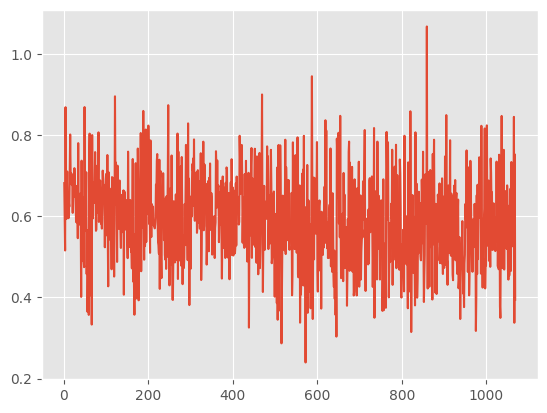

In [68]:
# 학습
subword_model.train()
subword_model = subword_model.to(device)
optimizer = torch.optim.Adam(subword_model.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss(reduction="mean")

step = 0
steps = []
loss_list = []

for e in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        sents, lengths, labels = batch
        sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
        out = subword_model(sents, lengths)

        optimizer.zero_grad()
        loss = loss_function(out.squeeze(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

plt.plot(steps, loss_list)

In [69]:
# 추론
subword_model.eval()
acc = []

for i, batch in enumerate(test_loader):
    sents, lengths, labels = batch
    sents, lengths, labels = sents.to(device), lengths.to(device), labels.to(device)
    out = subword_model(sents, lengths)

    probs = torch.sigmoid(out.squeeze(-1))
    preds = torch.zeros_like(probs).to(probs)
    preds[probs > 0.5] = 1.
    num_correct = ((preds == 1) * (labels == 1)).sum()
    acc.append(num_correct / len(labels))

print(f"Average accuracy: {sum(acc) / len(acc)}")

Average accuracy: 0.0
